# **Hidden Markov Model & Sequence Analysis**

This file contains all the work done during my internship, regrouped by weeks.

Compute this first to install the necessary libraries and mount google drive

In [ ]:
# @title Install
!pip install hmmlearn
!pip install graphviz
!pip install openpyxl
#from google.colab import drive
#drive.mount('/content/drive')

## **WEEK 14 & 15**

### **Power spectra per 10min. window**

HYPNOGRAMS :

Number of the sequence to process (excel row -1): 1

Processing sequence from excel's row 2: WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

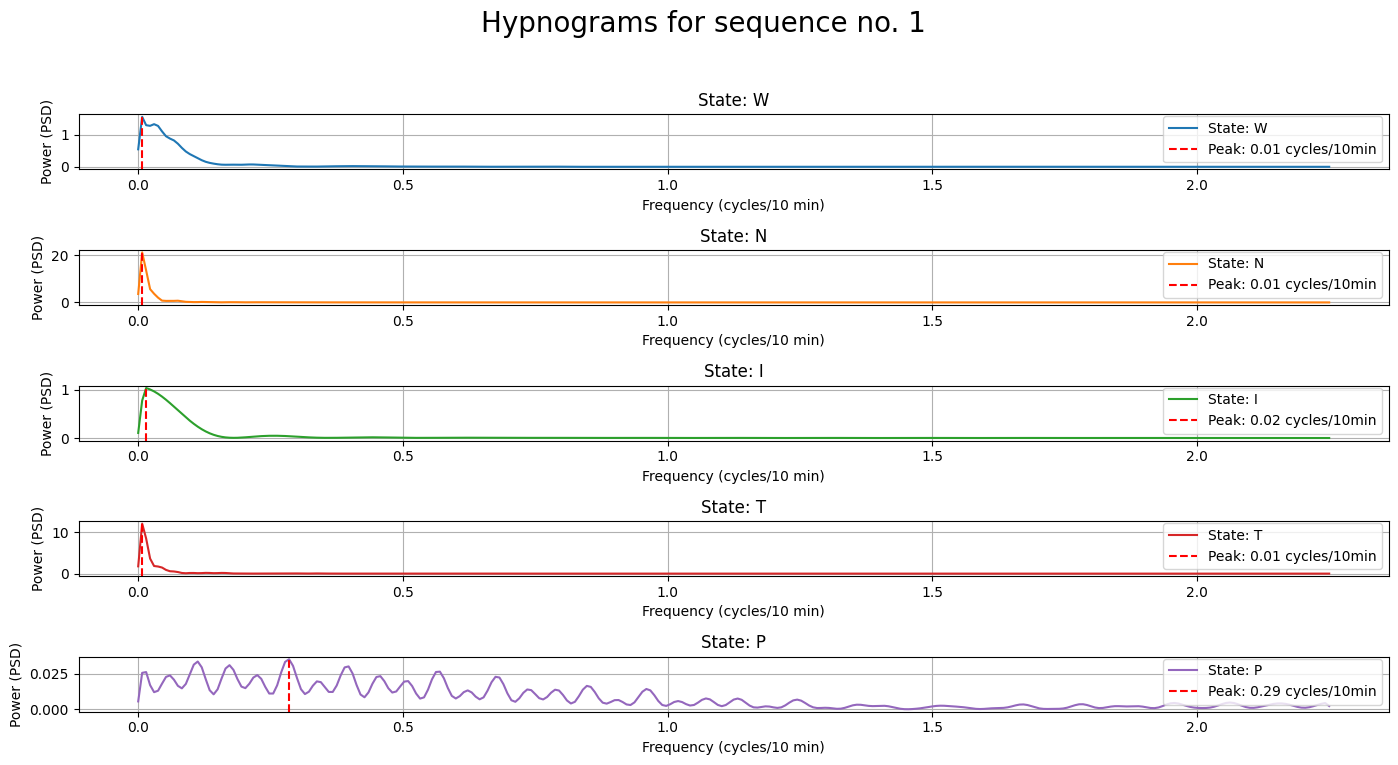

In [9]:
from scipy.signal import welch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load drive
file_path = '/content/drive/My Drive/string_analysis_hypno_latencies_tonic_phasic.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 11].dropna().tolist()

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    filtered_sequence = sequence # turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            None for char in filtered_sequence]

# AUTOMATIZATION
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]

# ---
time_per_step = 1  # 1 second
window_size = 10 * 60  # 10 minutes in seconds (600 time steps)
state_labels = ['W', 'N', 'I', 'T', 'P']


total_duration_minutes = len(original_sequence) * time_per_step / 60
conversion_factor = total_duration_minutes / 10  # Conversion to cycles per 10 minutes

plt.figure(figsize=(14, 8))
plt.suptitle(f"Hypnograms for sequence no. {row_num}", fontsize=20)

for i, state in enumerate(state_labels):
    binary_state_sequence = np.array([1 if x == (i + 1) else 0 for x in original_sequence])
    f, Pxx = welch(binary_state_sequence, fs=1/time_per_step, nperseg=600) # Computing Welch PSD
    f_cycles_per_10min = f * conversion_factor
    mask = f_cycles_per_10min <= 6
    dominant_frequency = f_cycles_per_10min[mask][np.argmax(Pxx[mask])]
    dominant_power = np.max(Pxx[mask])

    # Plot the periodogram PSD
    plt.subplot(len(state_labels), 1, i + 1)
    plt.plot(f_cycles_per_10min[mask], Pxx[mask], label=f"State: {state}", color=f"C{i}")
    plt.axvline(x=dominant_frequency, color='red', linestyle='--', label=f"Peak: {dominant_frequency:.2f} cycles/10min")
    plt.title(f"State: {state}")
    plt.xlabel("Frequency (cycles/10 min)")
    plt.ylabel("Power (PSD)")
    plt.grid(True)
    plt.legend()

    print(f"State {state}: Dominant Frequency = {dominant_frequency:.2f} cycles/10 min, Power = {dominant_power:.2f}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **WEEK 12**

### **Phasic Tonic Periods**

This code was used to extract the transitions in phasic and tonic sequences for each trial and save the data into the excel file. While running it on google colab you must have the excel file "string_analysis_hypno_latencies.xlsx" on your google drive.

In [ ]:
import pandas as pd
import numpy as np

# File path
file_path = '/content/drive/My Drive/string_analysis_hypno_latencies.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')

sequences = df.iloc[0:, 11].dropna().tolist()

num_transitions_list = []
transition_count_strings = []
num_periods_list = []
transitions_per_period_strings = []

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    return [1 if char == 'T' else
            2 if char == 'P' else
            None for char in filtered_sequence]

# Function to extract periods of T and P
def extract_periods(sequence):
    periods = []
    current_period = []
    for char in sequence:
        if char in ['T', 'P']:
            current_period.append(char)
        elif current_period:
            periods.append(current_period)
            current_period = []
    if current_period:
        periods.append(current_period)
    return periods

# Loop
for input_sequence in sequences:
    original_sequence = convert_sequence(input_sequence)
    original_sequence = [value for value in original_sequence if value is not None]

    # Number of transitions
    transitions = 0
    for i in range(1, len(original_sequence)):
        if original_sequence[i] != original_sequence[i - 1]:
            transitions += 1

    # Create transition count matrix for the whole sequence
    n_states = 2
    transition_count_matrix = np.zeros((n_states, n_states))
    for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
        transition_count_matrix[current_state - 1, next_state - 1] += 1

    # Generate transition count string for the whole sequence
    transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
    num_transitions_list.append(transitions)
    transition_count_strings.append(transition_count_string)

    # Extract periods and calculate their properties
    periods = extract_periods(input_sequence)
    num_periods_list.append(len(periods))

    # Calculate transitions for each period
    transitions_in_periods = []
    for period in periods:
        converted_period = convert_sequence(period)
        transitions = 0
        for i in range(1, len(converted_period)):
            if converted_period[i] != converted_period[i - 1]:
                transitions += 1
        transitions_in_periods.append(transitions)
    transitions_per_period_strings.append(', '.join(map(str, transitions_in_periods)))


#SAVING IN EXCEL
"""
# Write the results to new columns
df.loc[0:, 'PT Transitions Whole Sequence'] = num_transitions_list  # Transitions for the whole sequence
df.loc[0:, 'Transition matrix Whole Sequence'] = transition_count_strings  # Transition matrix for the whole sequence
df.loc[0:, 'Number of TP Periods'] = num_periods_list  # Number of T-P periods
df.loc[0:, 'Transitions per Period'] = transitions_per_period_strings  # Transitions in each period as a comma-separated array

# Save the updated DataFrame back to the Excel file
df.to_excel(file_path, sheet_name='Feuil1', index=False)
print("Results have been written to the Excel sheet.")
"""

### **Latency count**

This code was used to proces the latency count for each state (how long does it take until the first occurance of each sleep state). It saves the data in the excel file.

In [ ]:
import pandas as pd
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns

loop_count = 0

# Load the Excel file
file_path = '/content/drive/My Drive/string_analysis_hypno.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')

sequences = df.iloc[0:, 11].dropna().tolist() # Extract the sequences

first_N = []
first_R = []
first_T = []
first_P = []

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            None for char in filtered_sequence]

# Loop
for input_sequence in sequences:
    loop_count += 1
    print(f"\nSequence no. {loop_count}")

    # Process sequence
    original_sequence = convert_sequence(input_sequence)
    original_sequence = [value for value in original_sequence if value is not None]
    original_sequence = convert_sequence(original_sequence)

    # Find first appearances of 'N', 'R', 'T', 'P'
    first_appearance = {state: None for state in ['N', 'R', 'T', 'P']}
    for idx, char in enumerate(input_sequence):
        if char == 'N' and first_appearance['N'] is None:
            first_appearance['N'] = idx
        elif char == 'R' and first_appearance['R'] is None:
            first_appearance['R'] = idx
        elif char == 'T' and first_appearance['T'] is None:
            first_appearance['T'] = idx
        elif char == 'P' and first_appearance['P'] is None:
            first_appearance['P'] = idx

    print(f"First appearance of 'N': {first_appearance['N']}")
    print(f"First appearance of 'R': {first_appearance['R']}")
    print(f"First appearance of 'T': {first_appearance['T']}")
    print(f"First appearance of 'P': {first_appearance['P']}")

    # Append results to lists
    first_N.append(first_appearance['N'])
    first_R.append(first_appearance['R'])
    first_T.append(first_appearance['T'])
    first_P.append(first_appearance['P'])

#SAVING IN EXCEL
"""
# Write results back to DataFrame (starting from row 1 to match the sequence rows)
df.loc[0:, 'G'] = first_N  # Column G for first appearance of 'N'
df.loc[0:, 'H'] = first_R  # Column H for first appearance of 'R'
df.loc[0:, 'I'] = first_T  # Column I for first appearance of 'T'
df.loc[0:, 'J'] = first_P  # Column J for first appearance of 'P'

# Ensure column names match Excel layout
df.columns = df.columns.tolist()[:6] + ['G', 'H', 'I', 'J'] + df.columns.tolist()[10:]

# Save the updated DataFrame back to the Excel file
df.to_excel(file_path, sheet_name='Feuil1', index=False)
print("\nFirst appearances have been written to columns G, H, I, and J in the Excel sheet.")
"""

## **WEEK 9, 10 & 11**

### **Automatized version for excel file**

In this version, while running it on google colab you must have the excel file "iterations_transitions_accuracy.xlsx" in your google drive. Then you can choose the nuber of the sequence you want to compute the if you write "1" it will compute the first sequence of the excel file (excel's row 2). So for example if you want to compute the sequence on row 200 of the excel file you should write "199" when running the code.

Number of the sequence to process (excel row -1): 59

Processing sequence from excel's row 60: WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

<ipython-input-4-a26916e0fdf1>:59: RuntimeWarning: invalid value encountered in divide
  transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


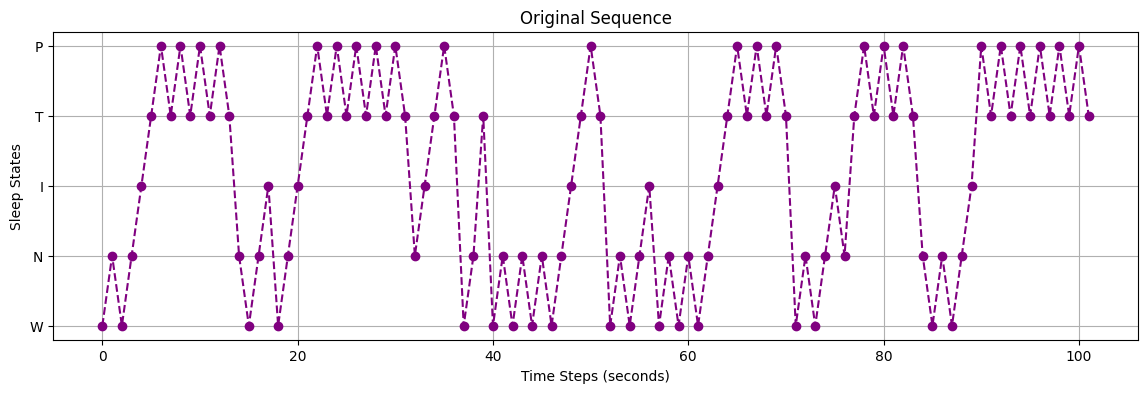


0, 18, 0, 0, 0, 11, 0, 9, 2, 0, 2, 1, 0, 5, 1, 4, 3, 0, 0, 22, 0, 0, 0, 23, 0


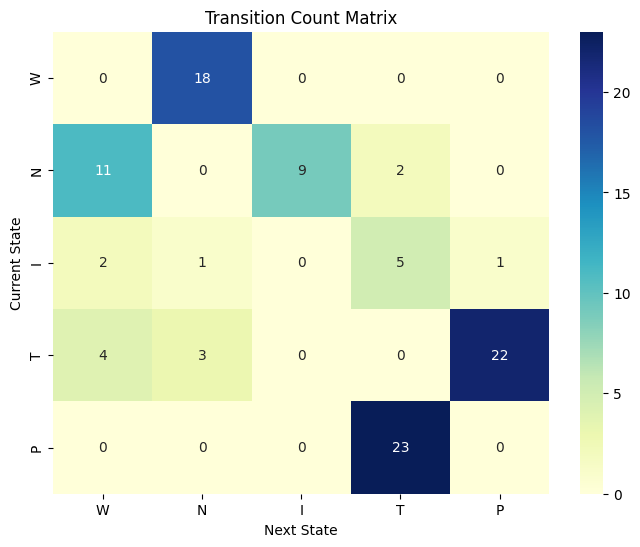

<ipython-input-4-a26916e0fdf1>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.96])


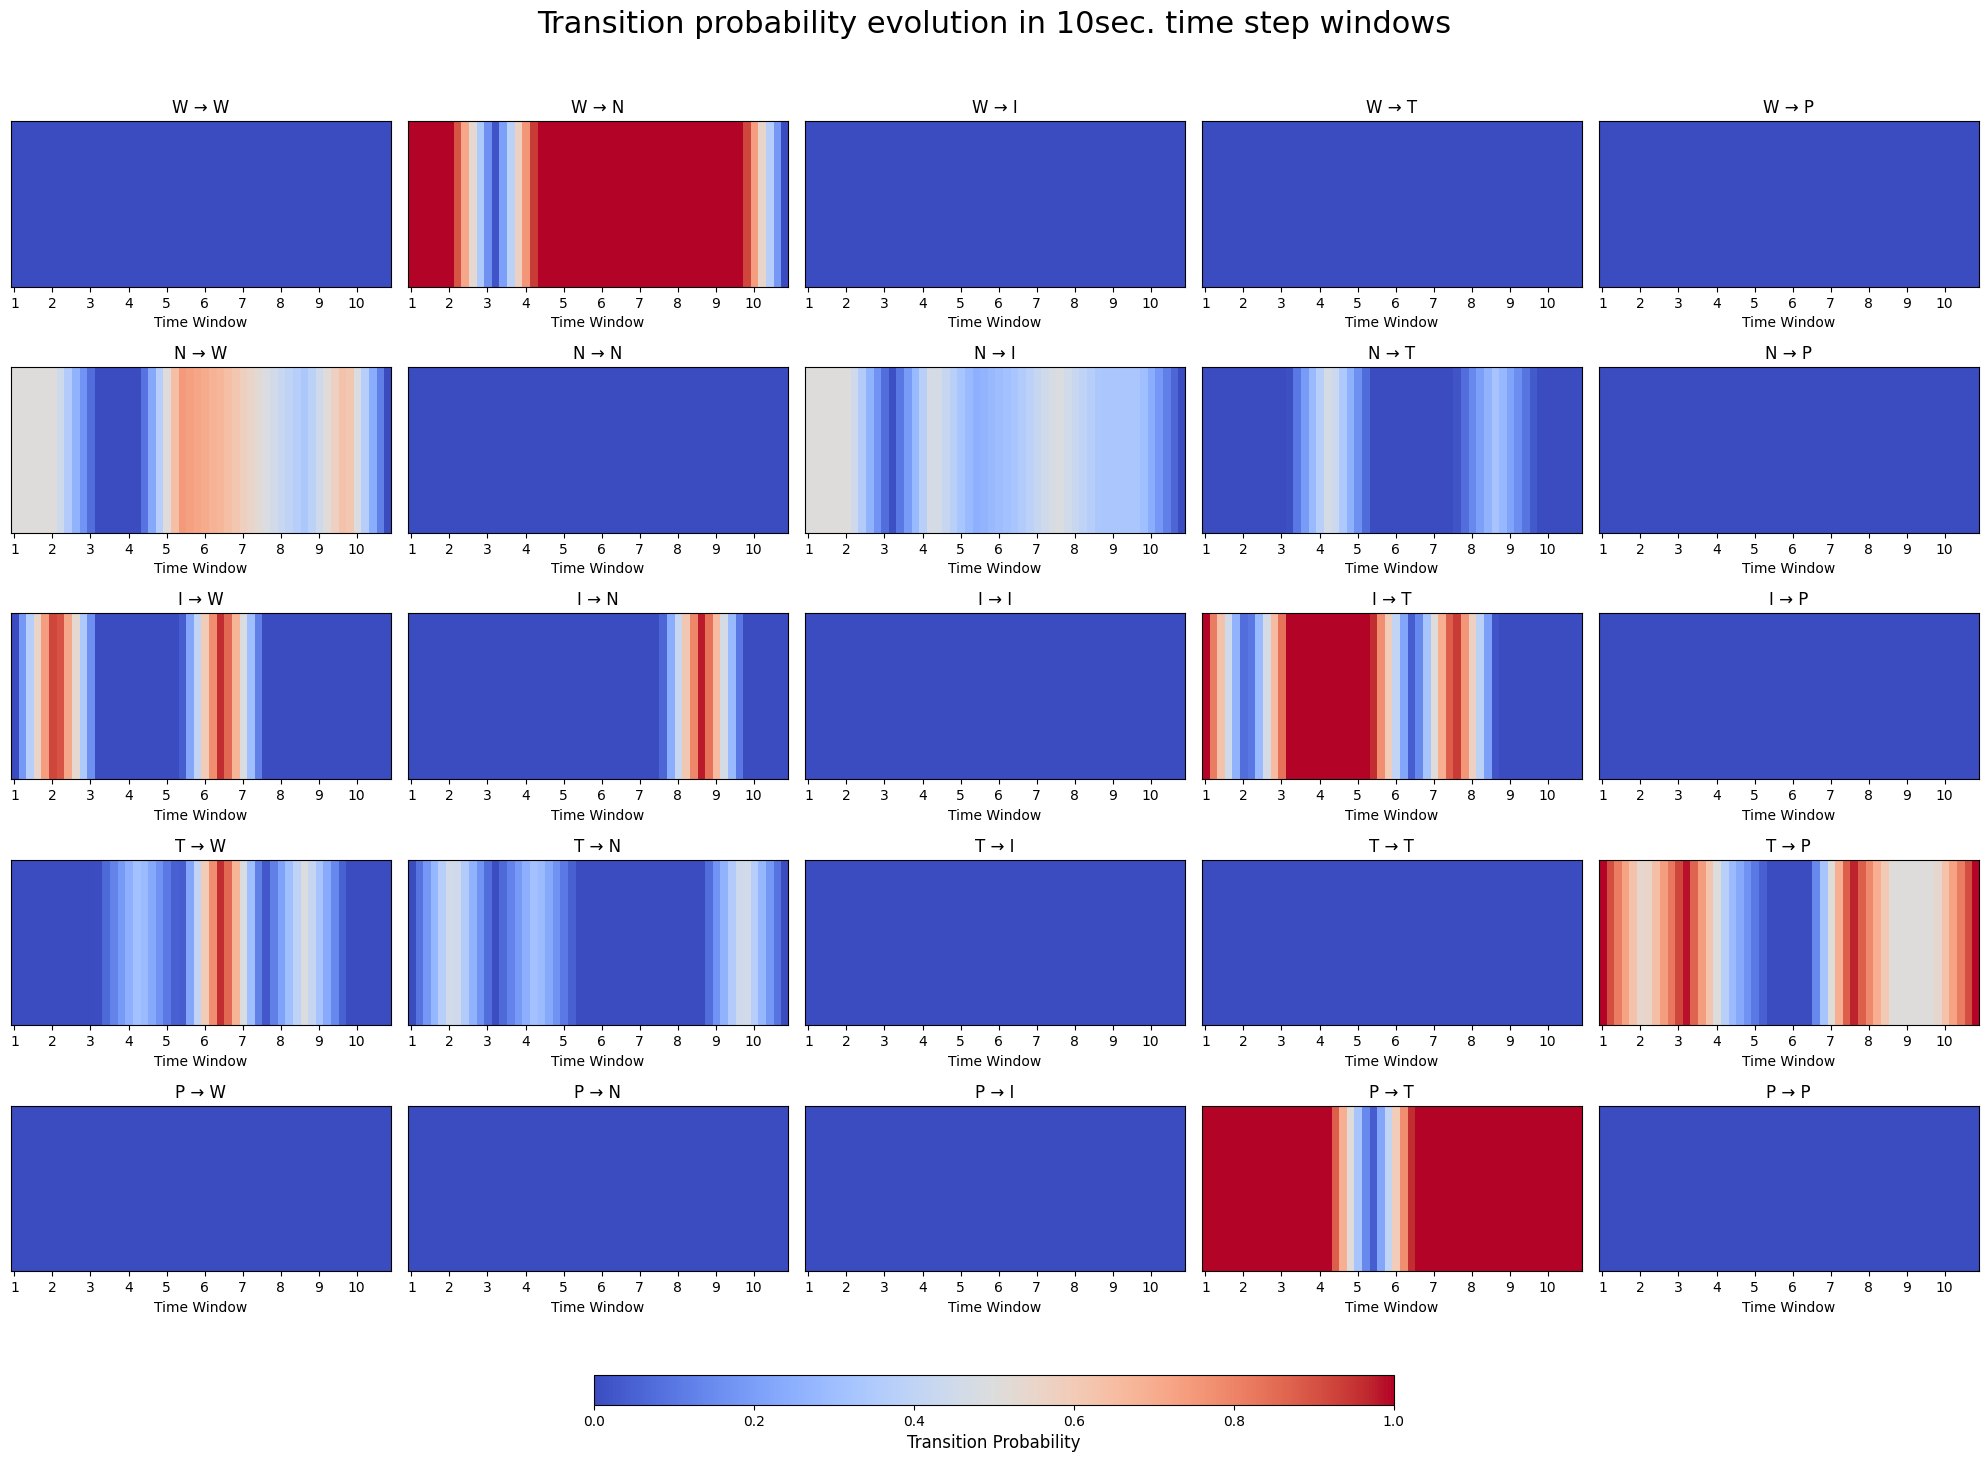

In [ ]:
import pandas as pd
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = sequence #turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]

# AUTOMATIZATION
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

# Define number of states and time window size
n_states = 5
time_step_window = 10

# Number of transitions calculation
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# Transition matrices for each window
transition_matrices = []
num_windows = len(original_sequence) // time_step_window

for w in range(num_windows):
    window_sequence = original_sequence[w * time_step_window:(w + 1) * time_step_window]
    transition_matrix = np.zeros((n_states, n_states))

    for (current_state, next_state) in zip(window_sequence[:-1], window_sequence[1:]):
        transition_matrix[current_state - 1, next_state - 1] += 1
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
    transition_matrices.append(transition_matrix)

print(f"Number of transitions between states: {transitions}")
print("")

plt.figure(figsize=(14, 4))
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Sleep States")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)
plt.show()


# Transition count matrix
transition_count_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_count_matrix[current_state - 1, next_state - 1] += 1

transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
print("")
print(transition_count_string)

state_labels = ['W', 'N', 'I', 'T', 'P']
plt.figure(figsize=(8, 6))
sns.heatmap(transition_count_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
                xticklabels=state_labels, yticklabels=state_labels)
plt.title("Transition Count Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
#plt.savefig(f"transition_matrix{row_num+1}.svg", format="svg")
plt.show()
print("")


# Heatmaps
fig, axes = plt.subplots(n_states, n_states, figsize=(20, 15))
for i in range(n_states):
    for j in range(n_states):
        probabilities = [matrix[i, j] for matrix in transition_matrices]
        probabilities = np.nan_to_num(probabilities, nan=0.0)
        probability_array = np.array(probabilities).reshape(1, -1)
        smooth_array = zoom(probability_array, (1, 5), order=1)
        im = axes[i, j].imshow(smooth_array, aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
        axes[i, j].set_title(f'{state_labels[i]} → {state_labels[j]}')
        axes[i, j].set_yticks([])
        axes[i, j].set_xticks(range(0, smooth_array.shape[1], 5))
        axes[i, j].set_xticklabels(range(1, num_windows + 1))
        axes[i, j].set_xlabel("Time Window")

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal").set_label("Transition Probability", fontsize=12)
fig.suptitle('Transition probability evolution in 10sec. time step windows', fontsize=22)
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
#plt.savefig(f"heatmap{row_num+1}.svg", format="svg")  # Save as SVG
plt.show()


### **Automatized version for the entire excel table**

This version produces the same outputs as above but here it goes trough the entire table. It takes around 20 minutes to compute trough all the sequences.

In [ ]:
!pip install hmmlearn
!pip install graphviz
import pandas as pd
from scipy.ndimage import zoom
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns

loop_count=0

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence = input_sequence #turn on if you want to enable state to itself transitions
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]

# Loop
for input_sequence in sequences:
    print("")
    loop_count+=1
    print(f"Sequence no. {loop_count}")
    #print(f"Processing sequence: {input_sequence}")

    original_sequence = convert_sequence(input_sequence)
    original_sequence = [value for value in original_sequence if value is not None]
    original_sequence = convert_sequence(original_sequence)

    n_states = 5
    time_step_window = 10

    transitions = 0
    for i in range(1, len(original_sequence)):
        if original_sequence[i] != original_sequence[i - 1]:
            transitions += 1

    transition_matrices = []
    num_windows = len(original_sequence) // time_step_window

    for w in range(num_windows):
        window_sequence = original_sequence[w * time_step_window:(w + 1) * time_step_window]
        transition_matrix = np.zeros((n_states, n_states))

        for (current_state, next_state) in zip(window_sequence[:-1], window_sequence[1:]):
            transition_matrix[current_state - 1, next_state - 1] += 1
        transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
        transition_matrices.append(transition_matrix)

    print(f"Number of transitions between states: {transitions}")

    plt.figure(figsize=(14, 4))
    plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
    plt.title("Original Sequence")
    plt.xlabel("Time Steps")
    plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
    plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
    plt.grid(True)
    plt.show()


    transition_count_matrix = np.zeros((n_states, n_states))
    for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
        transition_count_matrix[current_state - 1, next_state - 1] += 1

    transition_count_string = ', '.join([', '.join(map(lambda x: str(int(x)), row)) for row in transition_count_matrix])
    print(transition_count_string)

    state_labels = ['W', 'N', 'I', 'T', 'P']
    plt.figure(figsize=(8, 6))
    sns.heatmap(transition_count_matrix, annot=True, fmt=".0f", cmap="YlGnBu",
                xticklabels=state_labels, yticklabels=state_labels)
    plt.title("Transition Count Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.show()

    fig, axes = plt.subplots(n_states, n_states, figsize=(20, 15))
    for i in range(n_states):
        for j in range(n_states):
            probabilities = [matrix[i, j] for matrix in transition_matrices]
            probabilities = np.nan_to_num(probabilities, nan=0.0)
            probability_array = np.array(probabilities).reshape(1, -1)
            smooth_array = zoom(probability_array, (1, 5), order=1)
            im = axes[i, j].imshow(smooth_array, aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
            axes[i, j].set_title(f'{state_labels[i]} → {state_labels[j]}')
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks(range(0, smooth_array.shape[1], 5))
            axes[i, j].set_xticklabels(range(1, num_windows + 1))
            axes[i, j].set_xlabel("Time Window")

    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal").set_label("Transition Probability", fontsize=12)
    fig.suptitle('Heatmaps', fontsize=22)
    plt.tight_layout(rect=[0, 0.1, 1, 0.96])
    plt.show()


## **WEEK 8 (HMM)**

### *Whole table all states (most complete HMM version)*

This code, having the hmm setup to suit the type of sequences from the xlsx file, achieves between 100% and 60% of prediction accuracy. It has been automatized but can be switched to manual if you delete the automatic part of the code and remove the """ around the manual part.

Number of the sequence to process (excel row -1): 1


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Processing sequence from excel's row 2: WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

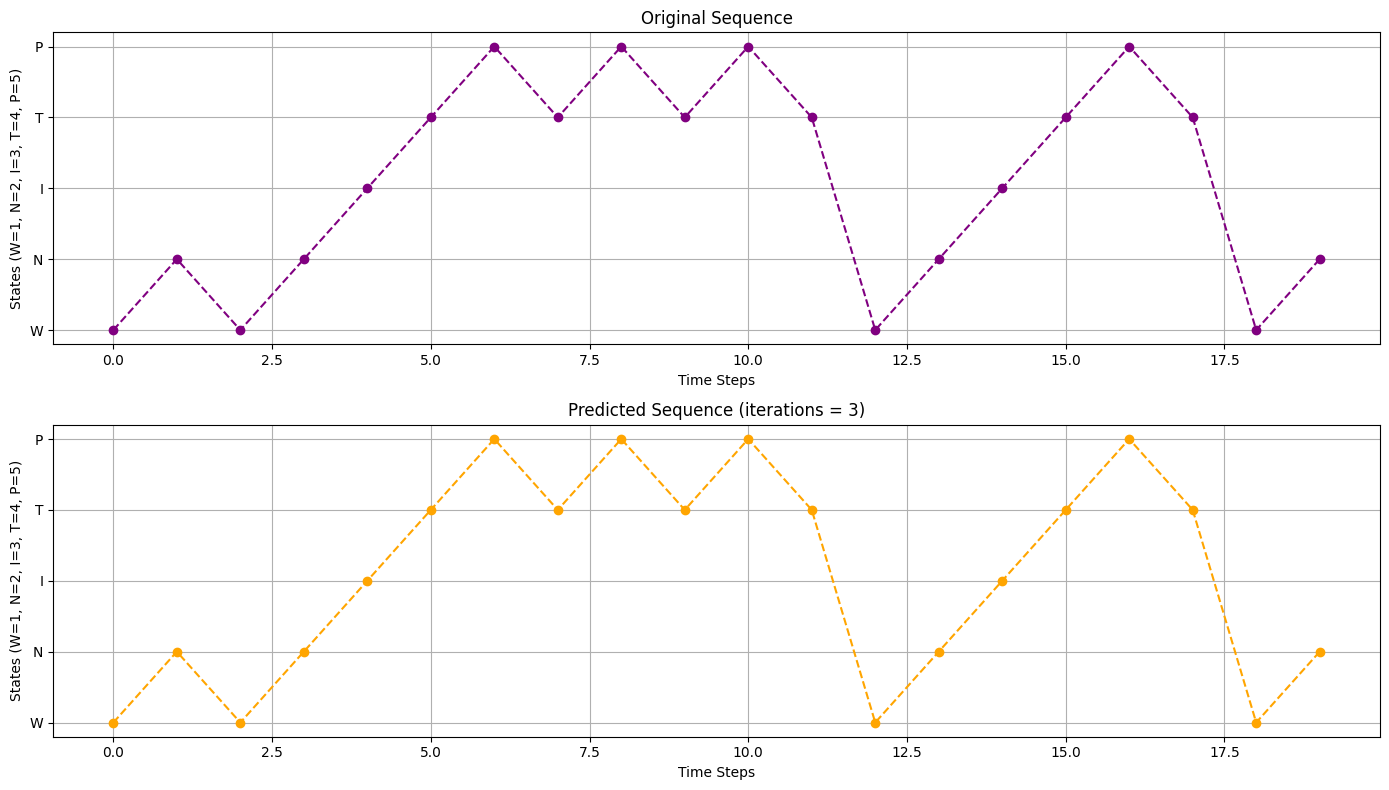


TRANSITION PROBABILITIES:
W → W: 0.0000
W → N: 1.0000
W → I: 0.0000
W → T: 0.0000
W → P: 0.0000
N → W: 0.3333
N → N: 0.0000
N → I: 0.6667
N → T: 0.0000
N → P: 0.0000
I → W: 0.0000
I → N: 0.0000
I → I: 0.0000
I → T: 1.0000
I → P: 0.0000
T → W: 0.3333
T → N: 0.0000
T → I: 0.0000
T → T: 0.0000
T → P: 0.6667
P → W: 0.0000
P → N: 0.0000
P → I: 0.0000
P → T: 1.0000
P → P: 0.0000



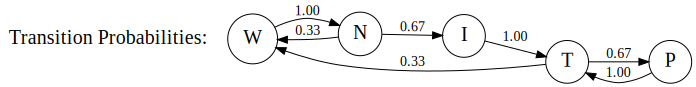

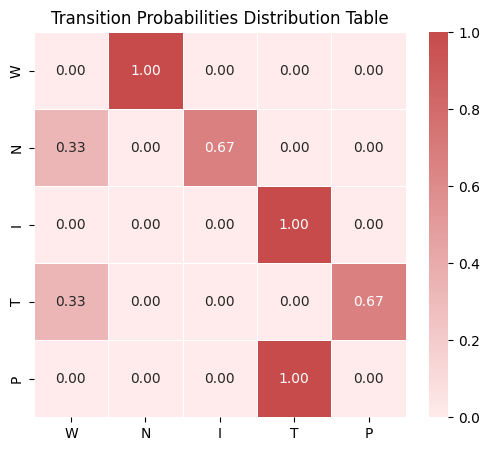

In [ ]:
"""
To setup the HMM model :
- change n_states to the number of hidden states in the sequence
- in the EMISSION MATRIX init. adjust its randomness by changing the
  multiplication coefficient (*1.421 in this specific case)
- adjust the MAXIMUM number of iterations max_iterations if necessary
- if you want to add 'state to itself repetitions', remove the "#" before the
  filtered_sequence=sequence line in the convert_sequence function

Reminder:
Run the !pip install lines the first time to install the libraries

"""

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence=sequence
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]
# MANUAL
"""
input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

print("Filtered sequence:", original_sequence)
"""

# AUTOMATIZED
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]  # Adjust row number to match the zero-indexed list
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
#n_states = int(input("n_states: "))  # Number of hidden states
n_states = 5
n_features = n_states

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# TRANSITION MATRIX
np.random.seed(42)  # ensuring reproducibility
transition_matrix = np.random.rand(n_states, n_states)  # Completely random transition matrix
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX init. (slightly randomized identity matrix)
emission_matrix = np.eye(n_states, n_features) + np.random.rand(n_states, n_features)*1.421
emission_matrix /= emission_matrix.sum(axis=1, keepdims=True)


# Convert observed sequence to 0-based indexing & set up observed counts for HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states, tol=0.0001, n_iter=10, random_state=42, init_params='')

# RANDOM START PROBABILITIES
startprob = np.random.rand(n_states)
startprob /= startprob.sum()
model.startprob_ = startprob

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
max_accuracy = 0
max_iterations = 400  # can change that depending on the dataset
while accuracy < 1.0 and iterations < max_iterations:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
    print(f"Iteration {iterations}: {accuracy * 100:.2f}%")

# OUTPUTS ----------------------------------------------------------------------

print(f"\nTraining stopped at {iterations} iterations.")
print("")
#print(f"input : {input_sequence}")
print(f"Accuracy (max. reached by predicted sequence): {max_accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.tight_layout()
plt.show()


print("\nTRANSITION PROBABILITIES:")
for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        print(f"{state1} → {state2}: {model.transmat_[i, j]:.4f}")

# TRANSITION GRAPH
print("")
# Initialize the directed graph
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

# Title for the graph
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities:', shape='plaintext', fontsize='20', fontcolor='black')

# Define the nodes for each state
states = ['W', 'N', 'I', 'T', 'P']
for state in states:
    dot.node(state, label=state, shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')

# Add edges based on non-zero transition probabilities
for i, state1 in enumerate(states):
    for j, state2 in enumerate(states):
        probability = model.transmat_[i, j]
        if probability > 0.001:
            dot.edge(state1, state2, label=f'{probability:.2f}', color='black', penwidth='1', fontcolor='black')

# Display the graph
display(dot)

# PROBABILITY DISTRIBUTION TABLE
proba_matrix = model.transmat_[:5, :5]
proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['W', 'N', 'I', 'T', 'P'],
                               index=['W', 'N', 'I', 'T', 'P'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Transition Probabilities Distribution Table')
plt.show()

DRAFT : changed for data extraction

Number of the sequence to process (excel row -1): 2


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Processing sequence from excel's row 3: WWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTTTPPTTTTTTTTTTTPPTTTTTPTTTPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

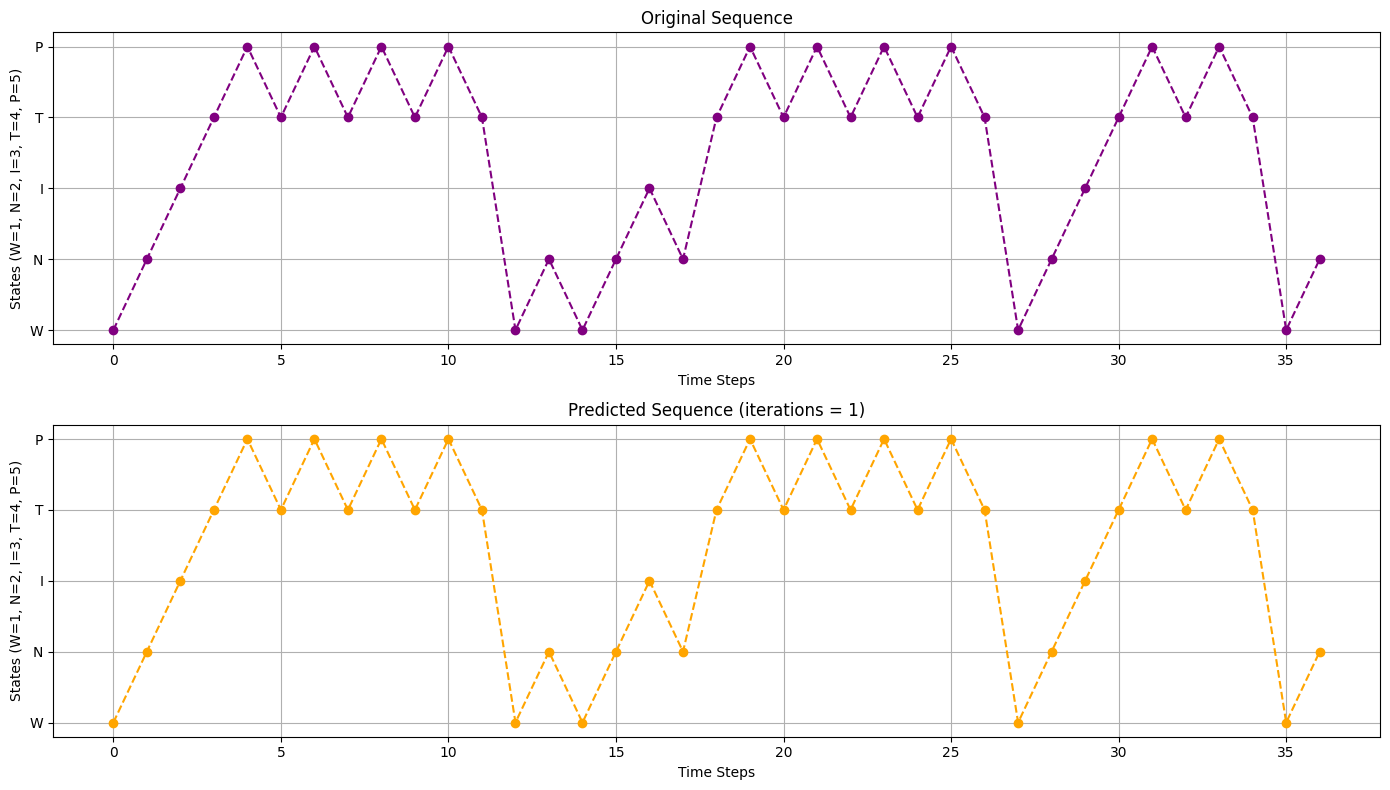


TRANSITION PROBABILITIES:
W → W: 0.0000
W → N: 1.0000
W → I: 0.0000
W → T: 0.0000
W → P: 0.0000
N → W: 0.1898
N → N: 0.0000
N → I: 0.6102
N → T: 0.2000
N → P: 0.0000
I → W: 0.0000
I → N: 0.3445
I → I: 0.0000
I → T: 0.6555
I → P: 0.0000
T → W: 0.2308
T → N: 0.0000
T → I: 0.0000
T → T: 0.0000
T → P: 0.7692
P → W: 0.0000
P → N: 0.0000
P → I: 0.0000
P → T: 1.0000
P → P: 0.0000


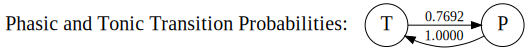

'\n\n# PROBABILITY DISTRIBUTION TABLE\nproba_matrix = model.transmat_[:5, :5]\nproba_matrix_df = pd.DataFrame(proba_matrix,\n                               columns=[\'W\', \'N\', \'I\', \'T\', \'P\'],\n                               index=[\'W\', \'N\', \'I\', \'T\', \'P\'])\n\ncolors = ["#FFEBEB", "#C74B4B"]\ncmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)\n\nplt.figure(figsize=(6, 5))\nsns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,\n            linewidths=0.5, linecolor=\'white\')\n\nplt.title(\'Transition Probabilities Distribution Table\')\nplt.show()\n'

In [ ]:
"""
DRAFT
"""

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

file_path = '/content/drive/My Drive/iterations_transitions_accuracy.xlsx'
df = pd.read_excel(file_path, sheet_name='Feuil1')
sequences = df.iloc[0:, 13].dropna().tolist()

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]
    #filtered_sequence=sequence
    return [1 if char == 'W' else
            2 if char == 'N' else
            3 if char == 'I' else
            4 if char == 'T' else
            5 if char == 'P' else
            1 if char == 1 else
            2 if char == 2 else
            3 if char == 3 else
            4 if char == 4 else
            5 if char == 5 else
            None for char in filtered_sequence]
# MANUAL
"""
input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

print("Filtered sequence:", original_sequence)
"""

# AUTOMATIZED
row_num = int(input(f"Number of the sequence to process (excel row -1): "))
sequence = sequences[row_num - 1]  # Adjust row number to match the zero-indexed list
print("")
print(f"Processing sequence from excel's row {row_num+1}: {sequence}")
original_sequence = convert_sequence(sequence)
original_sequence = [value for value in original_sequence if value is not None]
original_sequence = convert_sequence(original_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
#n_states = int(input("n_states: "))  # Number of hidden states
n_states = 5
n_features = n_states

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# TRANSITION MATRIX
np.random.seed(42)  # ensuring reproducibility
transition_matrix = np.random.rand(n_states, n_states)  # Completely random transition matrix
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX init. (slightly randomized identity matrix)
emission_matrix = np.eye(n_states, n_features) + np.random.rand(n_states, n_features)*1.421
emission_matrix /= emission_matrix.sum(axis=1, keepdims=True)


# Convert observed sequence to 0-based indexing & set up observed counts for HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states, tol=0.0001, n_iter=10, random_state=42, init_params='')

# RANDOM START PROBABILITIES
startprob = np.random.rand(n_states)
startprob /= startprob.sum()
model.startprob_ = startprob
print(startprob)

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
max_accuracy = 0
max_iterations = 400  # can change that depending on the dataset
while accuracy < 1.0 and iterations < max_iterations:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
    print(f"Iteration {iterations}: {accuracy * 100:.2f}%")

# OUTPUTS ----------------------------------------------------------------------

print(f"\nTraining stopped at {iterations} iterations.")
print("")
#print(f"input : {input_sequence}")
print(f"Accuracy (max. reached by predicted sequence): {max_accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.tight_layout()
plt.show()


# Display transition probabilities for all states for verification
print("\nTRANSITION PROBABILITIES:")
all_states = ['W', 'N', 'I', 'T', 'P']
for i, state1 in enumerate(all_states):
    for j, state2 in enumerate(all_states):
        print(f"{state1} → {state2}: {model.transmat_[i, j]:.4f}")

# Initialize the directed graph with SVG format
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Title for the graph
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Phasic and Tonic Transition Probabilities:', shape='plaintext', fontsize='20', fontcolor='black')

# Define only the Phasic (P) and Tonic (T) states
selected_states = ['T', 'P']
for state in selected_states:
    dot.node(state, label=state, shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')

# Mapping of all states to their indices in the transition matrix
state_index_map = {state: idx for idx, state in enumerate(all_states)}
tonic_index = state_index_map['T']
phasic_index = state_index_map['P']

# Check and add only relevant transitions for Phasic and Tonic states
for state1, state1_index in zip(selected_states, [tonic_index, phasic_index]):
    for state2, state2_index in zip(selected_states, [tonic_index, phasic_index]):
        probability = model.transmat_[state1_index, state2_index]

        # Only add edges with significant probability
        if probability > 0.001:
            dot.edge(state1, state2, label=f'{probability:.4f}', color='black', penwidth='1', fontcolor='black')

# Save the graph to SVG file
dot.render(filename=f"phasic_tonic_transition_graph{row_num}", format='svg')  # Saves as phasic_tonic_transition_graph.svg

# Display the graph (optional)
display(dot)
"""

# PROBABILITY DISTRIBUTION TABLE
proba_matrix = model.transmat_[:5, :5]
proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['W', 'N', 'I', 'T', 'P'],
                               index=['W', 'N', 'I', 'T', 'P'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Transition Probabilities Distribution Table')
plt.show()
"""

## **WEEK 7**

This is an older version of the Week 8 code with less features. It was used for the first full table analysis, having the hmm model setup to high performance results (close to 100% accuracy). This version is not automatized, thus the sequence has to be ctrl+c ctrl+v in the code.

In [ ]:
"""
Working for data in the sting_analysis_hypno.csv file

"""

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
  return [1 if char == 'W' else 2 if char == 'N' else 3 if char == 'I' else 4 if char == 'T' else 5 if char =='P' else 6 for char in sequence]
input_sequence = "_WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWNNNNNNNNNWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTPPPPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTTTTTTTTPPTTTTTTTTTTPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTTTTTPTTTTTTTTTTTTTTTTTTTTPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIPPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIITTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPPTTTTWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWWWWWWWWWWWWWWWWWWWWWWWWWWWNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNWWWW"
original_sequence = convert_sequence(input_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 6 # Number of hidden states

# NUMBER OF TRANSITIONS
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state,next_state) in zip(original_sequence[:-1],original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX
emission_matrix = np.eye(n_states)

# Convert observed sequence to 0-based indexing & set up observed counts for HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states,tol=0.01,random_state=42,init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
while accuracy < 1.0:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    print(f"Iteration {iterations}:{accuracy * 100:.2f}%")

# OUTPUTS ----------------------------------------------------------------------
# ------------------------------------------------------------------------------

print(f"\nTraining completed in {iterations} iterations.")
print("")
print(f"input : {input_sequence}")
#print(f"Original Sequence: {original_sequence}")
#print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")


plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='purple', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
#plt.xticks(np.arange(0, len(original_sequence), step=100))
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("States (W=1, N=2, I=3, T=4, P=5)")
#plt.xticks(np.arange(0, len(predicted_sequence), step=100))
plt.yticks([1, 2, 3, 4, 5], labels=['W', 'N', 'I', 'T', 'P'])
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nTRANSITION PROBABILITIES:")
for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        print(f"{state1} → {state2}: {transition_matrix[i, j]:.4f}")

# TRANSITION GRAPH
print("")
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities:', shape='plaintext', fontsize='20', fontcolor='black')

dot.node('W', label='W', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('N', label='N', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('I', label='I', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('T', label='T', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('P', label='P', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')

for i, state1 in enumerate(['W', 'N', 'I', 'T', 'P']):
    for j, state2 in enumerate(['W', 'N', 'I', 'T', 'P']):
        if transition_matrix[i, j] > 0:
            dot.edge(state1, state2, label=f'{transition_matrix[i, j]:.2f}', color='black', penwidth='1', fontcolor='black')

display(dot)

# PROBABILITY DISTRIBUTION TABLE
proba_matrix = transition_matrix[:5, :5]
proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['W', 'N', 'I', 'T', 'P'],
                               index=['W', 'N', 'I', 'T', 'P'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Transition Probabilities Distribution Table')
plt.show()

## **WEEK 6 (HMM for PHASIC & TONIC sequences)**

### *HMM code for phasic & tonic*

seq: TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTTTTTTTTTTTTTTTTPTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTPTP


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Iteration 1:96.08%
Iteration 2:99.02%
Iteration 3:100.00%

Training completed in 3 iterations.

Accuracy (predicted sequence): 100.00%
Number of transitions between states: 7



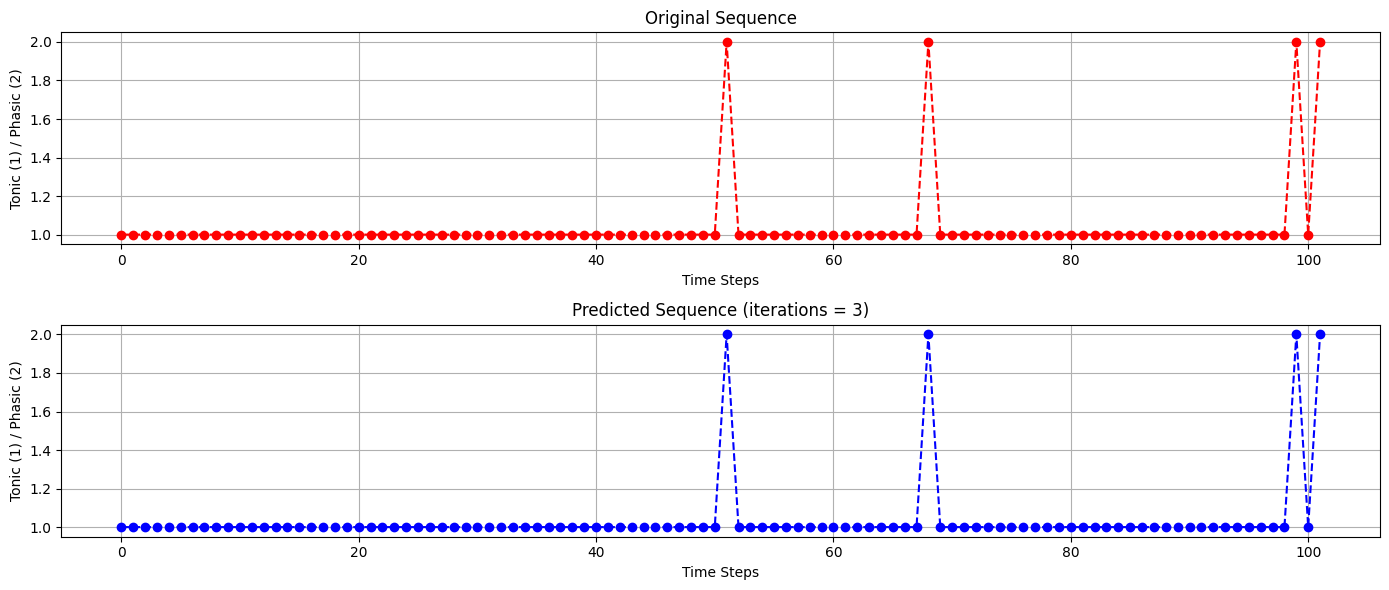


TRANSITION PROBABILITIES:
Staying in Tonic (1 → 1): 0.9592
Tonic to Phasic (1 → 2): 0.0408
Phasic to Tonic (2 → 1): 1.0000
Staying in Phasic (2 → 2): 0.0000



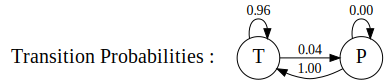

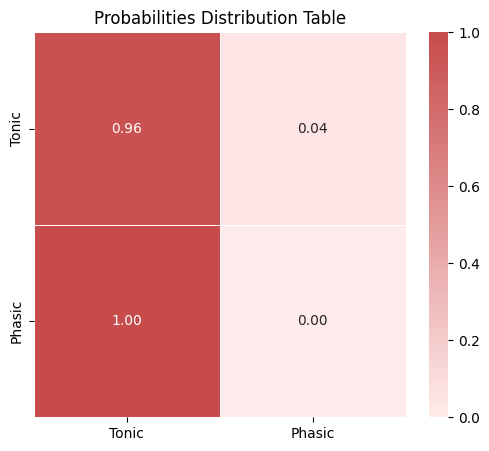

In [ ]:
"""
Adds automatic iterations counting & transition plots
Removed not used features for phasic/tonic analysis cf. Week 5 version
Adds char sequence to array converter in # ORIGINAL SEQUENCES section

"""

#!pip install hmmlearn
#!pip install graphviz

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# ORIGINAL SEQUENCES -----------------------------------------------------------

def convert_sequence(sequence):
    return [1 if char == 'T' else 2 for char in sequence]

input_sequence = input("seq: ")
original_sequence = convert_sequence(input_sequence)

# ------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 2  # Number of hidden states (tonic and phasic)

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL SETUP
model = hmm.MultinomialHMM(n_components=n_states, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
iterations = 0
accuracy = 0
while accuracy < 1.0:
    iterations += 1
    model.fit(observed_counts)
    predicted_sequence = model.predict(observed_counts) + 1
    accuracy = accuracy_score(original_sequence, predicted_sequence)
    print(f"Iteration {iterations}:{accuracy * 100:.2f}%")

# NUMBER OF TRANSITIONS --------------------------------------------------------
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# OUTPUTS ----------------------------------------------------------------------
print(f"\nTraining completed in {iterations} iterations.")
print("")
#print(f"Original Sequence: {original_sequence}")
#print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
print(f"Number of transitions between states: {transitions}")
print("")

# SEQUENCE PLOTS
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Tonic (1) / Phasic (2)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='blue', marker='o', linestyle='dashed')
plt.title(f"Predicted Sequence (iterations = {iterations})")
plt.xlabel("Time Steps")
plt.ylabel("Tonic (1) / Phasic (2)")
plt.grid(True)

plt.tight_layout()
plt.show()

# TRANSITION PROBABILITIES
p_Tonic_to_Tonic = transition_matrix[0, 0]
p_Tonic_to_Phase = transition_matrix[0, 1]
p_Phase_to_Tonic = transition_matrix[1, 0]
p_Phase_to_Phase = transition_matrix[1, 1]
print("\nTRANSITION PROBABILITIES:")
print(f"Staying in Tonic (1 → 1): {p_Tonic_to_Tonic:.4f}")
print(f"Tonic to Phasic (1 → 2): {p_Tonic_to_Phase:.4f}")
print(f"Phasic to Tonic (2 → 1): {p_Phase_to_Tonic:.4f}")
print(f"Staying in Phasic (2 → 2): {p_Phase_to_Phase:.4f}")

# 1
print("")
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
with dot.subgraph() as s:
    s.attr(rank='source')
    s.node('title', label='Transition Probabilities : ', shape='plaintext', fontsize='20', fontcolor='black')
dot.node('T', label='T', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.node('P', label='P', shape='circle', style='filled', fillcolor='white', fontcolor='black', fontsize='20')
dot.edge('T', 'T', label=f'{p_Tonic_to_Tonic:.2f}', color='black', fontcolor='black', penwidth='1', constraint='false')
dot.edge('P', 'P', label=f'{p_Phase_to_Phase:.2f}', color='black', fontcolor='black', penwidth='1', constraint='false')
dot.edge('T', 'P', label=f'{p_Tonic_to_Phase:.2f}', color='black', penwidth='1', fontcolor='black')
dot.edge('P', 'T', label=f'{p_Phase_to_Tonic:.2f}', color='black', penwidth='1', fontcolor='black')
display(dot)

# 2
print("")
proba_matrix = np.array([[p_Tonic_to_Tonic, p_Tonic_to_Phase],
                        [p_Phase_to_Tonic, p_Phase_to_Phase]])

proba_matrix_df = pd.DataFrame(proba_matrix,
                               columns=['Tonic', 'Phasic'],
                               index=['Tonic', 'Phasic'])

colors = ["#FFEBEB", "#C74B4B"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(proba_matrix_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
            linewidths=0.5, linecolor='white')

plt.title('Probabilities Distribution Table')
plt.show()


# **OLD HMM CODES**

Everything below is there just in case. They are old codes that don't work well enough and that I used to ultimately improve newer versions.

## **Week 1 to 5**

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


iterations: 40

Original Sequence: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
Predicted Sequence: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]

Original sequence length: 171
Accuracy (predicted sequence): 100.00%
Training iterations = 40

TRANSITION PROBABILITIES:
Staying in Tonic (1 → 1): 0.9503
Tonic to Phasic (1 → 2): 0.0497
Phasic to Tonic (2 → 1): 0.8889
Staying in Phasic (2 → 2): 0.1

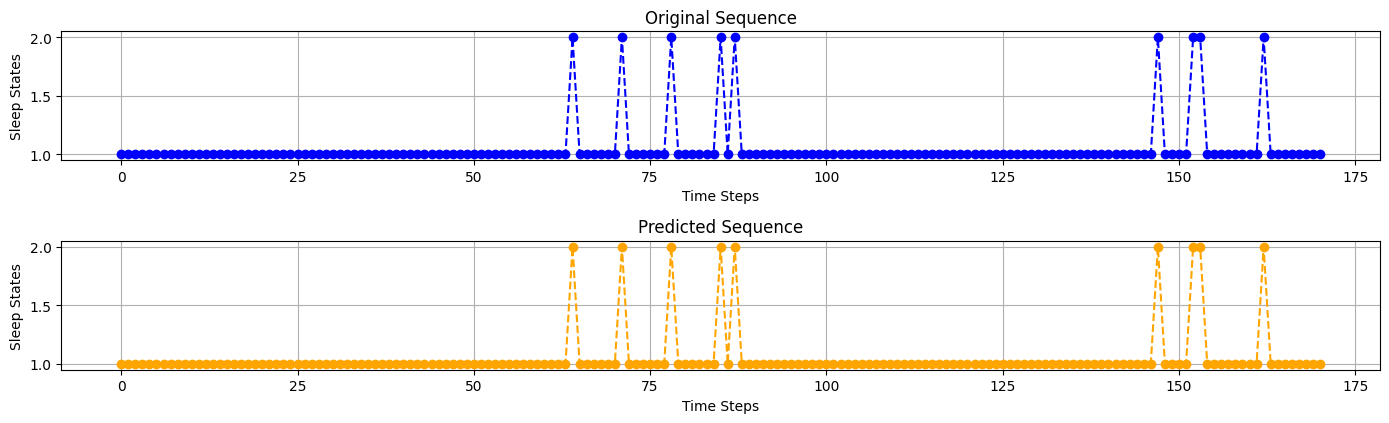

In [ ]:
# HMM Week 5 (has some impotant fearutres removed in week 6 version)
"""
Currently the original sequences are phasic & tonic data.
That's why n_states=2 and the smoothing part is put on comment in the code.
Remember to adjust the number of iterations in TRAINING part of the code.
"""

#!pip install hmmlearn #put line on comment after first run

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ORIGINAL SEQUENCES -----------------------------------------------------------

# CBD ctrl (csv line 1)
# has 100% accuracy with 44 iterations
#original_sequence=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# CBD tre (csv line 144)
# has 100% accuracy with 50 iterations
#original_sequence = [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# RGS tre (csv line 560)
# has 100% accuracy with 8 iterations
original_sequence=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1]

# RGS ctrl (csv line 649)
# has 100% accuracy with 1 iteration
#original_sequence=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#-------------------------------------------------------------------------------

original_sequence = np.array(original_sequence)
n_states = 2  # HERE change the number of states to suit original_sequence

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING ---------------------------------------------------------------------
#iterations = 1 #HERE change the number of iterations to train the model
iterations = int(input("iterations: "))
for _ in range(iterations):
    model.fit(observed_counts)
#-------------------------------------------------------------------------------

# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1

# SMOOTHING
def smooth_sequence(sequence):
    smoothed_sequence = []
    i = 0
    while i < len(sequence):
        count = 1
        while (i + 1 < len(sequence)) and (sequence[i] == sequence[i + 1]):
            count += 1
            i += 1
        if count > 1:
            smoothed_sequence.extend([sequence[i]] * count)
        else:
            if smoothed_sequence:
                smoothed_sequence.extend([smoothed_sequence[-1]] * count)
            else:
                smoothed_sequence.extend([sequence[i]] * count)
        i += 1
    return np.array(smoothed_sequence)

smoothed_sequence = smooth_sequence(predicted_sequence)

# REDUCTION
reduced_sequence = [smoothed_sequence[0]]
for i in range(1, len(smoothed_sequence)):
    if smoothed_sequence[i] != smoothed_sequence[i - 1]:
        reduced_sequence.append(smoothed_sequence[i])

reduced_sequence2 = [predicted_sequence[0]]
for i in range(1, len(predicted_sequence)):
    if predicted_sequence[i] != predicted_sequence[i - 1]:
        reduced_sequence2.append(predicted_sequence[i])

# NUMBER OF TRANSITIONS --------------------------------------------------------
transitions = 0
for i in range(1, len(original_sequence)):
    if original_sequence[i] != original_sequence[i - 1]:
        transitions += 1

# ACCURACY (%) & PROBABILITIES -------------------------------------------------
accuracy = accuracy_score(original_sequence, predicted_sequence)
accuracy2 = accuracy_score(original_sequence, smoothed_sequence)
print("")
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print("")
#print(f"Smoothed Sequence: {smoothed_sequence}")
#print("Reduced Sequence:", reduced_sequence)
print(f"Original sequence length: {len(original_sequence)}")
#print(f"Smoothed sequence length: {len(smoothed_sequence)}")
#print(f"Latent States (original): {len(reduced_sequence2)}")
#print(f"Latent States (smoothed): {len(reduced_sequence)}")
print(f"Accuracy (predicted sequence): {accuracy * 100:.2f}%")
#print(f"Accuracy (smoothed sequence): {accuracy2 * 100:.2f}%")
print(f"Training iterations = {iterations}")

p_Tonic_to_Tonic = transition_matrix[0, 0]
p_Tonic_to_Phase = transition_matrix[0, 1]
p_Phase_to_Tonic = transition_matrix[1, 0]
p_Phase_to_Phase = transition_matrix[1, 1]
print("")
print("TRANSITION PROBABILITIES:")
print(f"Staying in Tonic (1 → 1): {p_Tonic_to_Tonic:.4f}")
print(f"Tonic to Phasic (1 → 2): {p_Tonic_to_Phase:.4f}")
print(f"Phasic to Tonic (2 → 1): {p_Phase_to_Tonic:.4f}")
print(f"Staying in Phasic (2 → 2): {p_Phase_to_Phase:.4f}")
print(f"Number of transitions between states: {transitions}")

# FIGURES ----------------------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(3, 1, 1)
plt.plot(original_sequence, color='blue', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(predicted_sequence, color='orange', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

"""
plt.subplot(3, 1, 3)
plt.plot(smoothed_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Smoothed Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
"""

plt.tight_layout()
plt.show()



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [3 2 2 5 5 5 5 4 4 4 4 1 4 4 4 4 4 1 2 2 2 2 2 2 2 2 2 2 4 4 1 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3
 3 3 3 3 5 5 5 2 2 2 2 2 2 1 1 1 1 4 5 5 5 5 5 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 3 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 2 2 1 1 1 1 3 3 3 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4
 2 2 2 2 2 2 2 2 2 1 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 1 1 1 5 2 2 2 2 2 2 2 2
 2 4 4 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 2 2 2 4 4 4 4 4
 4 4 4 4 4 2 2 2 2 1 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3 3 3 1 3 3 3 3 3 3 3
 4 4 4 4 2 2 2 2 2 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 1 1 4 4 4]
Predicted Sequence: [3 2 2 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 4 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2

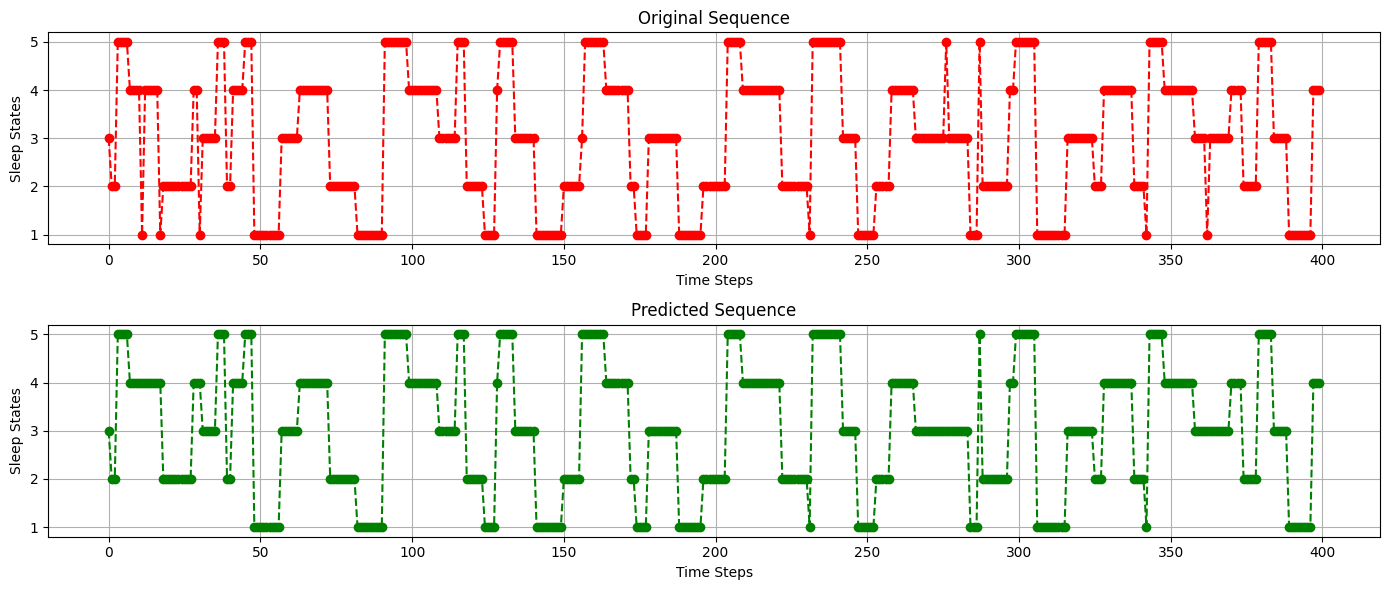

In [ ]:
# @title HMM V1
# this is the best one so far

# install hmmlearn first time running on colab : (line below)
# !pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [3, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 4, 4, 4, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4]


original_sequence = np.array(original_sequence)
n_states = 5  # hidden states

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)  # normalize row-wise

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1  # convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # start with the same state as original sequence
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING
iterations = 100
for _ in range(iterations):
    model.fit(observed_counts)


# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # adjust back to 1-based indexing


# REDUCTION OF LATENT STATES
reduced_sequence = [predicted_sequence[0]]
for i in range(1, len(predicted_sequence)):
    if predicted_sequence[i] != predicted_sequence[i - 1]:
        reduced_sequence.append(predicted_sequence[i])

# ACCURACY (%)
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print("Reduced Sequence:", reduced_sequence)
print(f"Original sequence length: {len(original_sequence)}")
print(f"Reduced sequence length: {len(reduced_sequence)}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# FIGURES
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [1 2 2 3 3 3 3 3 3 4 4 5 5 1 2 2 2 3 3 3 3 3 3 4 4 4 5 5 5 1 2 3 3 3 3 4 4
 5 1 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 5 5 5 5 1 2 2 3 3 3 3 3 4 4 5 5 5 5 1 2

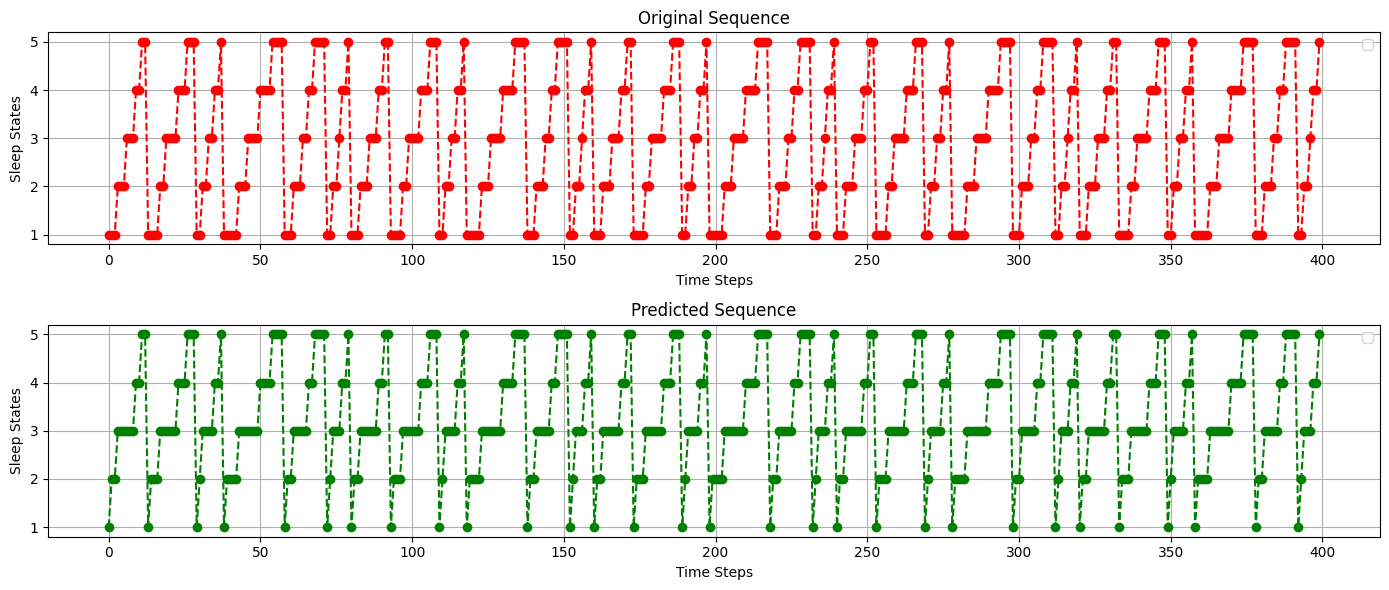

In [ ]:
# @title [old] 5

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)
!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

#Transition matrix
n_states = 5
transition_matrix = np.zeros((n_states, n_states))

for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)  # Normalize transition matrix

#Emission matrix
emission_matrix = np.eye(n_states)

#HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # each observation is a single trial

observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)  # create observed counts for HMM

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

#Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01, random_state=42)
start_state = original_sequence[0] - 1  # Convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # Set 100% start probability at the initial state of the original sequence

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix
model.n_trials = n_trials

#Fit the model to the observed counts
model.fit(observed_counts)

#Predict the sequence
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

#Accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

#figures
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [4 5 3 3 3 3 3 3 3 4 4 2 2 2 2 1 5 3 3 3 3 3 3 4 4 4 2 2 2 1 5 3 3 3 3 4 4
 2 2 2 2 1 5 3 3 3 3 3 3 3 4 4 4 4 2 2 2 2 2 1 5 3 3 3 3 3 4 4 2 2 2 2 1 5

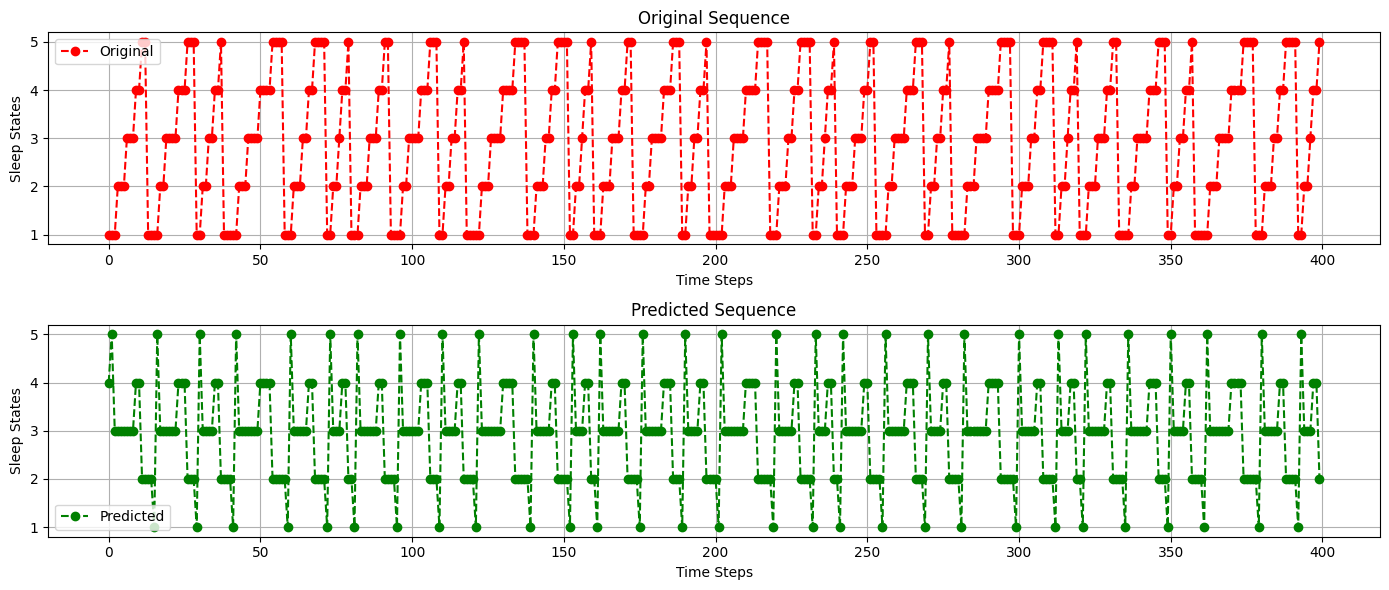

In [ ]:
# @title [old] 6

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)

!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Original sequence with a repeating pattern
original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

n_states = 5

# HMM - Preprocessing the observed sequence
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # Convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # Each observation is a single trial

# Create observed counts for the HMM
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

# Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42)

# Number of iterations to refine the model
iterations = 5

# Train the model iteratively
for _ in range(iterations):
    model.fit(observed_counts)

# Predict the sequence using the trained model
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

# Calculate accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Original'])

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Predicted'])

plt.tight_layout()
plt.show()


# **Creating a random sequence :**

In [ ]:
import numpy as np

sequence = []

while len(sequence) < 400:
    numbers = np.random.permutation([1, 2, 3, 4, 5])
    for number in numbers:
        repetition = np.random.randint(1, 11)
        sequence.extend([number] * repetition)
    if len(sequence) >= 400:
        sequence = sequence[:400]
        break

print("Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:")
print(sequence)

Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 1, 1, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3, 

In [ ]:
#@title reading a .npz file
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
b = np.load('/content/drive/MyDrive/run_results_posttrial5_RGS14/latentStates.npz')
print(b.files)
array_name = input()
if array_name in b.files:
    print(f"\nArray '{array_name}':\n", b[array_name])
else:
    print(f"Array '{array_name}' not found in the file.")